In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

In [4]:
import tensorflow as tf

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)



In [7]:
print(os.listdir('train'))
print(os.listdir(os.path.join('train','Covid19')))

['Covid19', 'Normal', 'Viral_Pneumonia']
['01.jpeg', '010.png', '012.jpeg', '015.jpg', '019.png', '02.jpeg', '020.jpg', '021.jpeg', '022.jpeg', '024.jpeg', '025.jpeg', '026.jpeg', '027.jpeg', '03.jpeg', '031.jpeg', '032.jpeg', '033.png', '039.jpeg', '04.png', '040.jpeg', '041.jpeg', '042.jpeg', '043.jpeg', '044.jpeg', '045.jpeg', '046.jpeg', '047.jpeg', '048.jpeg', '049.jpeg', '050.jpeg', '051.jpeg', '052.jpeg', '053.jpeg', '054.jpeg', '055.jpeg', '056.jpg', '057.jpeg', '058.jpeg', '059.jpeg', '06.jpeg', '060.jpeg', '061.jpg', '062.jpeg', '064.jpg', '065.jpeg', '067.jpg', '068.jpg', '069.jpg', '07.jpg', '071.jpg', '072.jpeg', '073.jpg', '074.jpg', '076.jpg', '078.jpeg', '079.jpeg', '08.jpeg', '080.jpg', '081.jpeg', '082.jpg', '083.jpeg', '084.jpeg', '085.jpeg', '086.jpg', '088.jpeg', '089.jpg', '09.png', '090.jpeg', '091.jpg', '092.png', 'COVID-00001.jpg', 'COVID-00002.jpg', 'COVID-00003a.jpg', 'COVID-00003b.jpg', 'COVID-00004.jpg', 'COVID-00005.jpg', 'COVID-00006.jpg', 'COVID-00007.jp

In [8]:
data=tf.keras.utils.image_dataset_from_directory('train',image_size=(224,224))

Found 251 files belonging to 3 classes.


In [9]:
data.class_names
# Class 0 = Covid19 , Class 1 = Normal , Class 2 = Viral_Pneumonia

['Covid19', 'Normal', 'Viral_Pneumonia']

In [10]:
data_iterator=data.as_numpy_iterator()

In [11]:
batch=data_iterator.next()

In [12]:
batch[0]

array([[[[4.1383924e+00, 4.1383924e+00, 4.1383924e+00],
         [3.8766389e+00, 3.8766389e+00, 3.8766389e+00],
         [3.1540184e+00, 3.1540184e+00, 3.1540184e+00],
         ...,
         [3.0000000e+00, 3.0000000e+00, 3.0000000e+00],
         [6.9936485e+00, 6.9936485e+00, 6.9936485e+00],
         [8.5693359e+00, 8.5693359e+00, 8.5693359e+00]],

        [[3.0000000e+00, 3.0000000e+00, 3.0000000e+00],
         [4.0000000e+00, 4.0000000e+00, 4.0000000e+00],
         [4.0000000e+00, 4.0000000e+00, 4.0000000e+00],
         ...,
         [4.7343750e+00, 4.7343750e+00, 4.7343750e+00],
         [5.2922363e+00, 5.2922363e+00, 5.2922363e+00],
         [8.5693359e+00, 8.5693359e+00, 8.5693359e+00]],

        [[3.0000000e+00, 3.0000000e+00, 3.0000000e+00],
         [3.2924118e+00, 3.2924118e+00, 3.2924118e+00],
         [4.0000000e+00, 4.0000000e+00, 4.0000000e+00],
         ...,
         [4.1538086e+00, 4.1538086e+00, 4.1538086e+00],
         [6.3696480e+00, 6.3696480e+00, 6.3696480e+00],
  

In [13]:
print(len(batch))
print(batch[0].shape)
print(batch[1])

2
(32, 224, 224, 3)
[1 2 0 1 0 1 1 2 1 2 1 1 0 2 1 1 1 0 0 2 1 2 2 1 0 0 0 1 0 2 0 0]


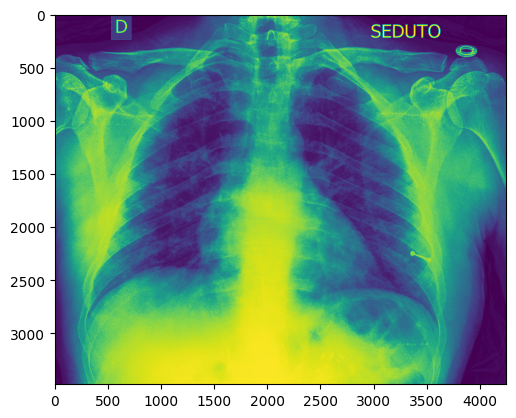

In [14]:
img=cv2.imread(os.path.join('train','Covid19','01.jpeg'))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

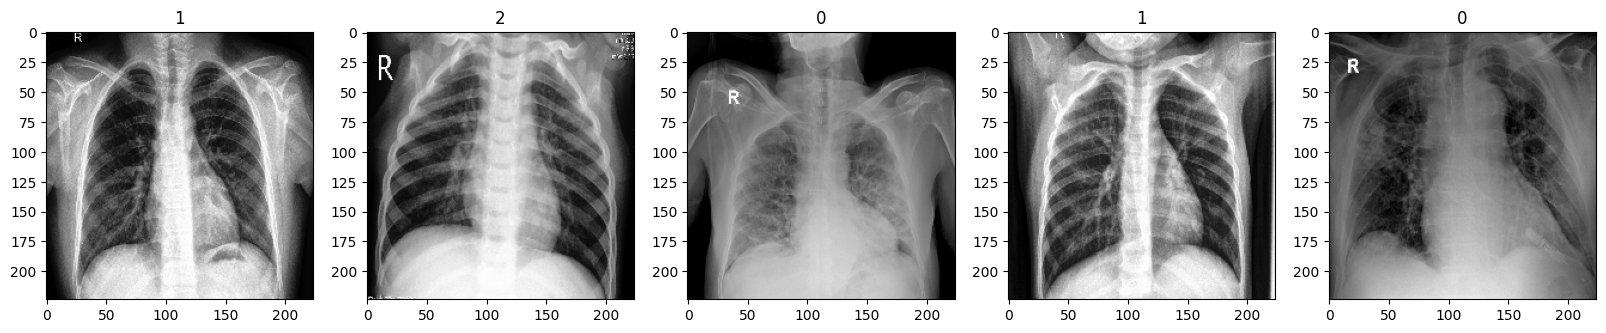

In [15]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
data=data.map(lambda x,y: (tf.image.rgb_to_grayscale(x)/255,y))

In [17]:
data_iterator=data.as_numpy_iterator()

In [18]:
batch=data_iterator.next()

In [19]:
print(batch[0].min())
print(batch[0].max())

0.0
0.99990004


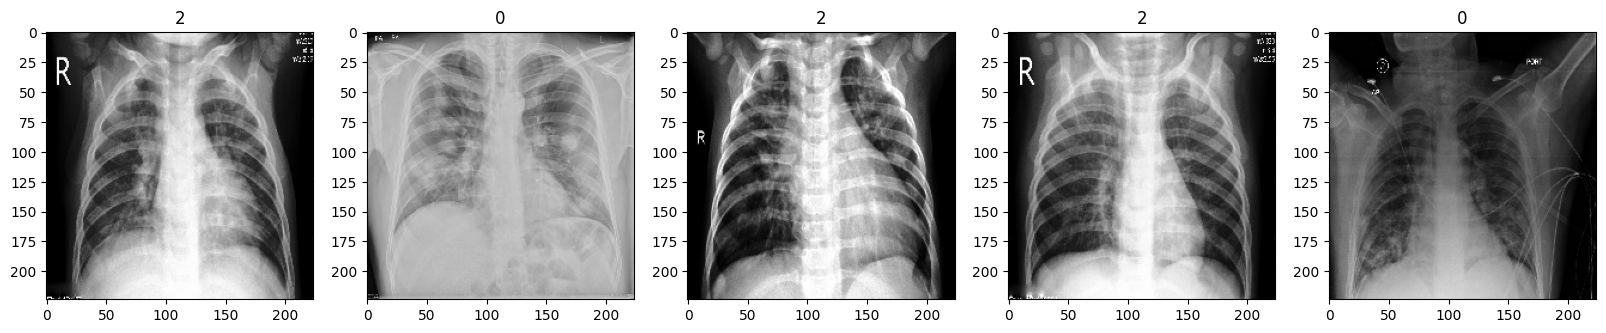

In [20]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate(batch[0][:5]):
    ax[idx].imshow(img,cmap='gray')
    ax[idx].title.set_text(batch[1][idx])

In [21]:
test_data=tf.keras.preprocessing.image_dataset_from_directory('test',label_mode=None,image_size=(224,224),batch_size=32)
print(test_data.class_names)
test_data=test_data.map(lambda x: (tf.image.rgb_to_grayscale(x)/255))

Found 132 files belonging to 1 classes.
['']


In [22]:
for images in test_data.take(1):
    print(images.shape)

(32, 224, 224, 1)


In [23]:
test_images=[]
for images in test_data:
    test_images.append(images[0])
print(test_images[0].shape)

(224, 224, 1)


In [24]:
test_data_iterator=test_data.as_numpy_iterator()

In [25]:
test_batch=test_data_iterator.next()

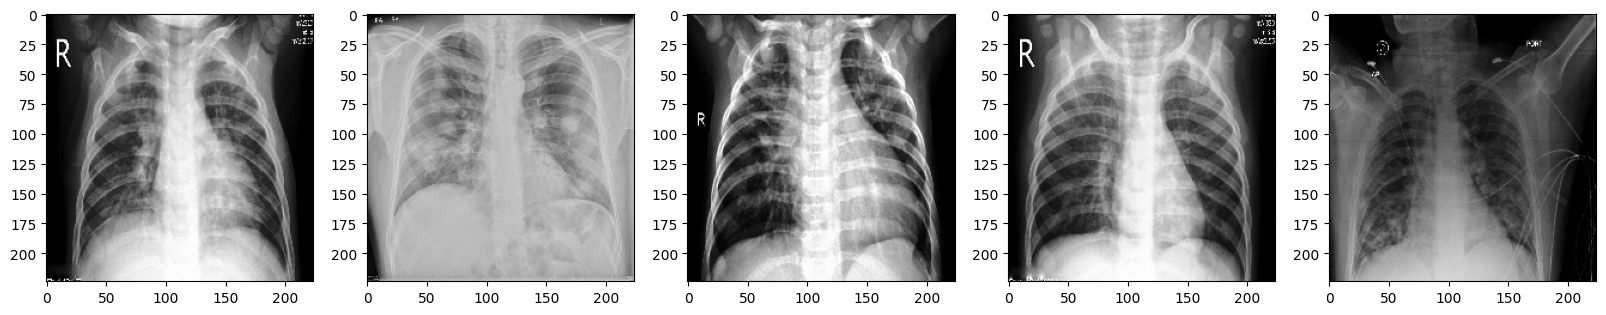

In [26]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate (batch[0][:5]):
    ax[idx].imshow(img,cmap='gray')

In [27]:
print(test_batch[0])
print(test_batch[0].max())
print(test_batch[0].min())

[[[0.9447835 ]
  [0.9604482 ]
  [0.94102234]
  ...
  [0.9902766 ]
  [0.98585373]
  [0.9896372 ]]

 [[0.9851156 ]
  [0.99283797]
  [0.96068823]
  ...
  [0.9899395 ]
  [0.99277866]
  [0.99213773]]

 [[0.9752726 ]
  [0.9429629 ]
  [0.9337601 ]
  ...
  [0.9934585 ]
  [0.99990004]
  [0.9981993 ]]

 ...

 [[0.15814833]
  [0.06856056]
  [0.03785128]
  ...
  [0.07674344]
  [0.07898404]
  [0.07842354]]

 [[0.09506856]
  [0.04623392]
  [0.04271279]
  ...
  [0.07674344]
  [0.07562337]
  [0.07842354]]

 [[0.08618615]
  [0.02798847]
  [0.04645409]
  ...
  [0.07674344]
  [0.07562337]
  [0.07842354]]]
0.99990004
0.0


In [28]:
len(test_data)

5

In [29]:
len(data)

8

In [43]:
train_size = 5 
val_size = 2
test_size = 1
model_test_size = 5

In [44]:
train = data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [45]:
model_test=test_data.take(model_test_size)

In [46]:
print(len(train))
print(len(val))
print(len(test))

5
2
1


In [47]:
for images, labels in train.take(1):
    print("Image shape:", images.shape)
    print("Image min/max values:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
    print("Labels shape:", labels.shape)
    print("Unique labels:", np.unique(labels))

Image shape: (32, 224, 224, 1)
Image min/max values: 0.0 0.99990004
Labels shape: (32,)
Unique labels: [0 1 2]


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import HeNormal

In [49]:
tf.keras.backend.clear_session()

model = Sequential()

model.add(Input(shape=(224,224,1)))

model.add(Conv2D((16), (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D((32), (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D((64), (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense((256), activation='relu'))
model.add(Dense((3), activation='softmax'))

adam=Adam(learning_rate=0.001,clipnorm=1.0)
model.compile(optimizer=adam, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [50]:
logdir = 'logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [53]:
history = model.fit(train, epochs = 30, validation_data = val, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/30
5/5 [==============================] - 3s 395ms/step - loss: 1.1489 - accuracy: 0.5312 - val_loss: 1.0679 - val_accuracy: 0.5312
Epoch 2/30
5/5 [==============================] - 3s 361ms/step - loss: 0.7719 - accuracy: 0.7000 - val_loss: 0.5342 - val_accuracy: 0.7969
Epoch 3/30
5/5 [==============================] - 3s 355ms/step - loss: 0.2978 - accuracy: 0.9250 - val_loss: 0.2487 - val_accuracy: 0.8750
Epoch 4/30
5/5 [==============================] - 2s 340ms/step - loss: 0.2012 - accuracy: 0.8938 - val_loss: 0.9172 - val_accuracy: 0.8125
Epoch 5/30
5/5 [==============================] - 3s 381ms/step - loss: 0.3453 - accuracy: 0.8938 - val_loss: 0.2950 - val_accuracy: 0.8750
Epoch 6/30
5/5 [==============================] - 3s 367ms/step - loss: 0.2308 - accuracy: 0.9125 - val_loss: 0.0848 - val_accuracy: 0.9688
Epoch 7/30
5/5 [==============================] - 3s 400ms/step - loss: 0.1245 - accuracy: 0.9438 - val_loss: 0.0636 - val_accuracy: 0.9688
Epoch 8/30
5/5 [====

In [54]:
history.history

{'loss': [1.1488697528839111,
  0.7719318270683289,
  0.2978448271751404,
  0.20117470622062683,
  0.34534144401550293,
  0.2307697981595993,
  0.12453228235244751,
  0.11419136822223663,
  0.08587736636400223,
  0.06741639226675034,
  0.09161565452814102,
  0.031943053007125854,
  0.020495522767305374,
  0.017869533970952034,
  0.004483175929635763,
  0.011091168038547039,
  0.00638354429975152,
  0.0017928194720298052,
  0.004152952693402767,
  0.0016136907506734133,
  0.0006826409953646362,
  0.0005986809264868498,
  0.0005647398647852242,
  0.0004582623078022152,
  0.00031601902446709573,
  0.000272208359092474,
  0.00025775207905098796,
  0.00018301840464118868,
  0.00027663534274324775,
  0.0001402549387421459],
 'accuracy': [0.53125,
  0.699999988079071,
  0.925000011920929,
  0.893750011920929,
  0.893750011920929,
  0.9125000238418579,
  0.9437500238418579,
  0.956250011920929,
  0.9624999761581421,
  0.9750000238418579,
  0.9750000238418579,
  0.987500011920929,
  0.987500011

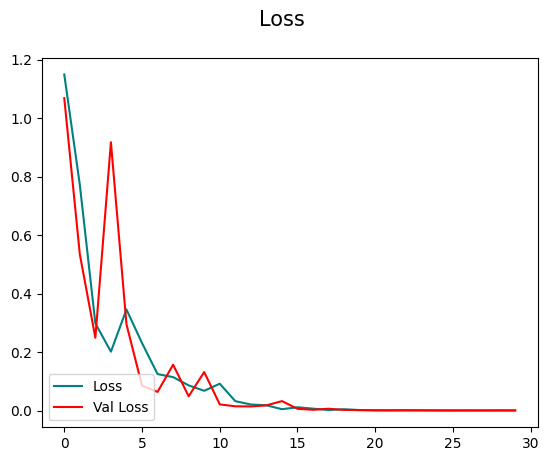

In [55]:
fig= plt.figure()
plt.plot(history.history['loss'], color='teal', label='Loss')
plt.plot(history.history['val_loss'], color='red', label='Val Loss')
fig.suptitle('Loss', fontsize=15)
plt.legend(loc='lower left')
plt.show()

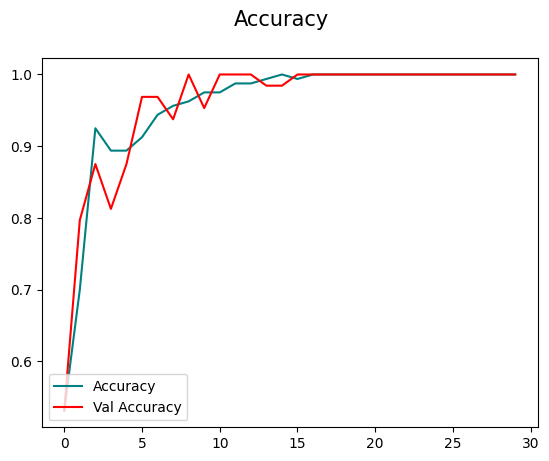

In [56]:
fig= plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Val Accuracy')
fig.suptitle('Accuracy', fontsize=15)
plt.legend(loc='lower left')
plt.show()

In [57]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pr = Precision()
re = Recall()
ca = CategoricalAccuracy()

In [58]:
len(test)

1

In [59]:
for batch in  test.as_numpy_iterator():
    X, y = batch
    yhat= model.predict(X)
    y = tf.one_hot(y, depth=3) #apply one hot encoding so that only one column has a value of 1 and the rest is 0
    pr.update_state(y,yhat)
    re.update_state(y,yhat)
    ca.update_state(y,yhat)    

1/1 [==============================] - 1s 675ms/step


In [60]:
print(y.shape,yhat.shape)

(27, 3) (27, 3)


In [61]:
print(pr.result().numpy(),re.result().numpy(),ca.result().numpy())

1.0 1.0 1.0


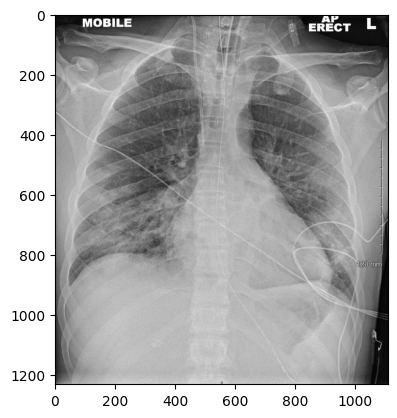

In [62]:
img = cv2.imread(r"test\\Covid19\\COVID (1).jpg",cv2.IMREAD_GRAYSCALE)
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.imshow(img,cmap='gray')
plt.show()

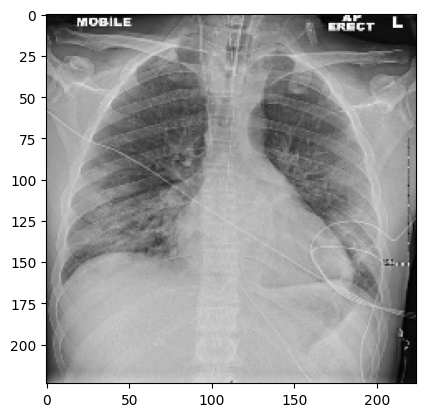

In [63]:
resize= cv2.resize(img, (224,224))
plt.imshow(resize,cmap='gray')
plt.show()

In [64]:
resize=np.expand_dims(resize,0)

In [65]:
resize = np.expand_dims(resize, axis=-1)

In [66]:
resize=resize/255.0

In [67]:
print(resize.shape)  # Should be something like (1, 224, 224, 1)

(1, 224, 224, 1)


In [68]:
yhat_test=model.predict(resize)

1/1 [==============================] - 0s 331ms/step


In [69]:
yhat_test

array([[1.0000000e+00, 1.9414904e-15, 3.9048724e-14]], dtype=float32)

In [70]:
pred_class = np.argmax(yhat_test, axis=1)
if pred_class[0]==0:
    print('Predicted class is Coronavirus.')
elif pred_class[0]==1:
    print('Predicted class is Normal.')
else: 
    print('Predicted class is Viral Pneumonia.')

Predicted class is Coronavirus.


In [71]:
pred_class[0]

0

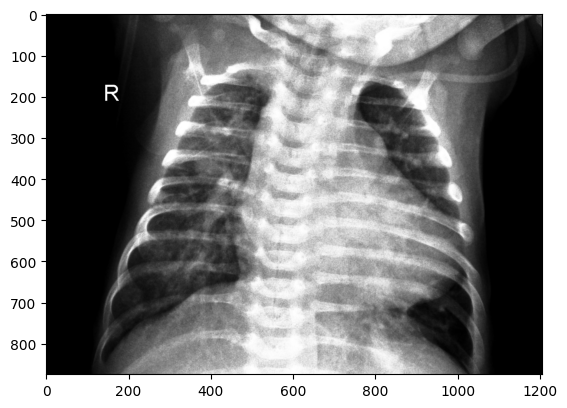

In [72]:
img = cv2.imread(r"test/Viral_Pneumonia/VP (19).jpeg",cv2.IMREAD_GRAYSCALE)
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.imshow(img,cmap='gray')
plt.show()

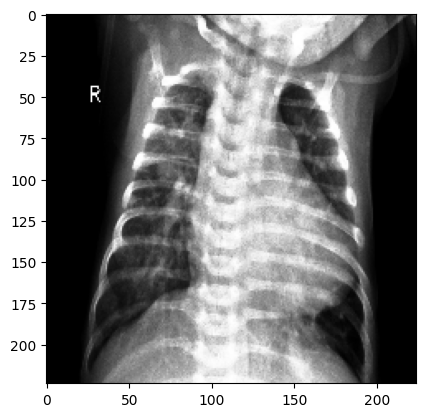

In [73]:
resize= cv2.resize(img, (224,224))
plt.imshow(resize,cmap='gray')
plt.show()

In [74]:
resize=np.expand_dims(resize,0)

In [75]:
resize = np.expand_dims(resize, axis=-1)

In [76]:
resize=resize/255.0

In [77]:
print(resize.shape)  # Should be something like (1, 224, 224, 1)

(1, 224, 224, 1)


In [78]:
yhat_test=model.predict(resize)

1/1 [==============================] - 0s 25ms/step


In [79]:
yhat_test

array([[3.8358943e-09, 2.7420376e-06, 9.9999726e-01]], dtype=float32)

In [80]:
pred_class = np.argmax(yhat_test, axis=1)
if pred_class[0]==0:
    print('Predicted class is Coronavirus.')
elif pred_class[0]==1:
    print('Predicted class is Normal.')
else: 
    print('Predicted class is Viral Pneumonia.')

Predicted class is Viral Pneumonia.


In [81]:
pred_class[0]

2

In [82]:
from tensorflow.keras.models import load_model

In [83]:
model.save(os.path.join('models','lung_disease_identification2.h5'))